# Website Visits: Page Loads - MIMO Stacked Convolutional Network

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Datasets" data-toc-modified-id="Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Datasets</a></span></li><li><span><a href="#Network" data-toc-modified-id="Network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Plain-network" data-toc-modified-id="Plain-network-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plain network</a></span></li><li><span><a href="#Seasonal-Network" data-toc-modified-id="Seasonal-Network-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Seasonal Network</a></span></li></ul></li><li><span><a href="#Validation" data-toc-modified-id="Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [3]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
from collections import OrderedDict
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader

import pytorch_fit
from pytorch_fit import fit, evaluate, train_epoch, evaluate
from pytorch_fit.metrics import Metric
from pytorch_fit.stopping import EarlyStopping
from pytorch_fit.visuals import (
    plot_history,
    display_last_history,
    display_network,
    format_vertical_headers,
)

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import IHSTransformer, get_smoothed
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_pytorch import set_trainable
from timeseries_pytorch.models import TimeWindowForecastingModel
from timeseries_pytorch.transform import get_exogenous_seasonal_dct_lst
from timeseries_pytorch.datasets import TimeWindowForecastingDataset
from timeseries_pytorch.metrics import OriginalMetric

from timeseries_data import WebsiteVisitsData

<IPython.core.display.Javascript object>

In [5]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = WebsiteVisitsData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

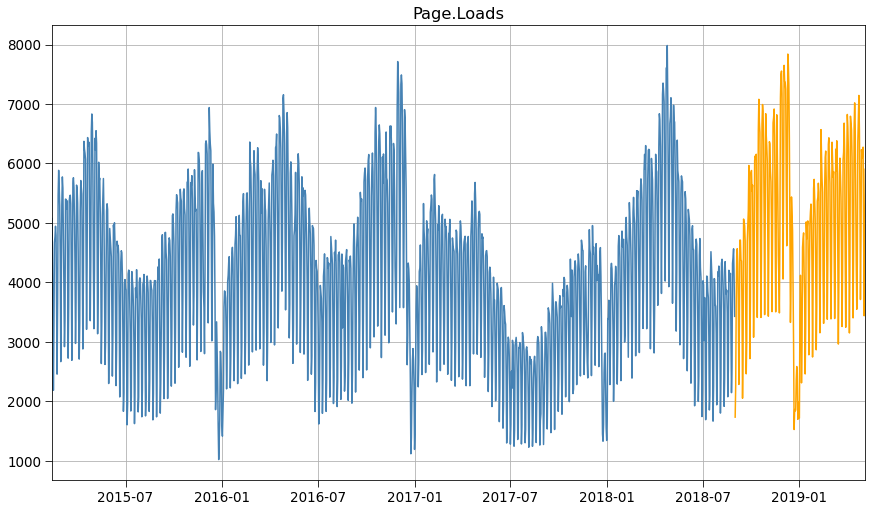

<IPython.core.display.Javascript object>

In [8]:
fig = plot_ts(train_intv.view())
plot_ts(val_intv.view(), color="orange", fig=fig)
display(fig)

Order of differencing: 1


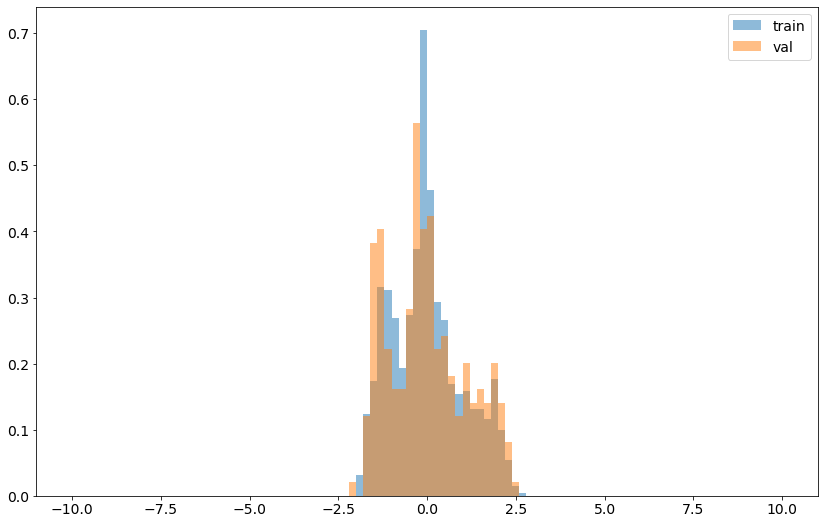

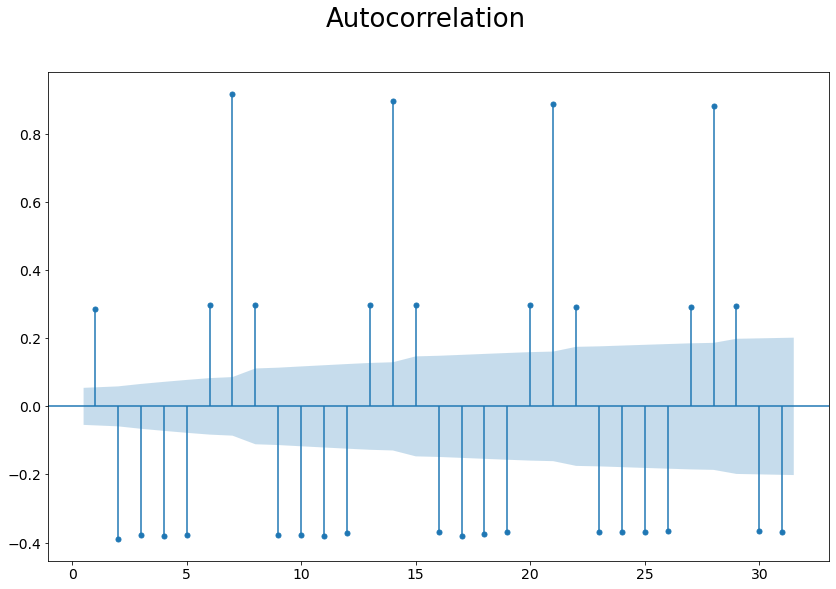

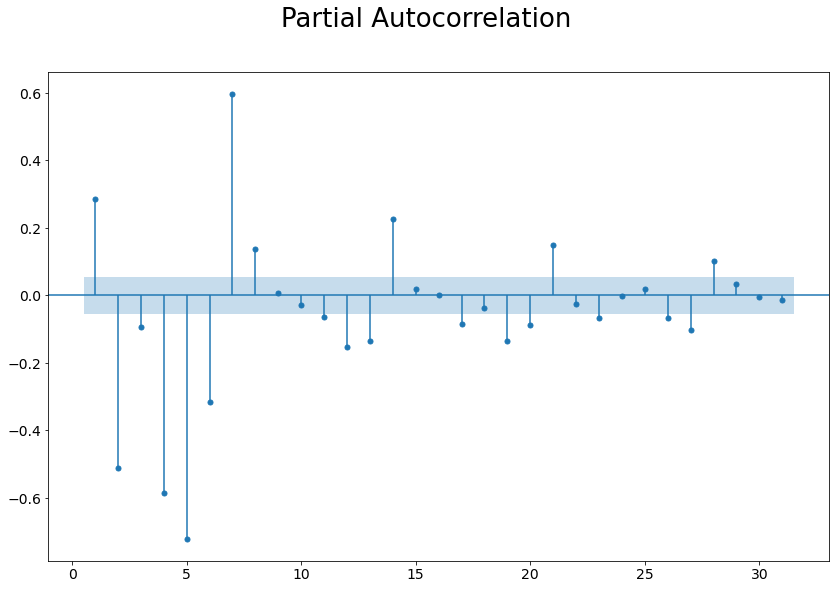

<IPython.core.display.Javascript object>

In [9]:
trans = IHSTransformer(train_intv.view(ts), lmb=None, verbose=True)
original_trans_ts = trans_ts = trans.transform(ts)

fig = plot_hist(
    train_intv.view(trans_ts), bins=100, range=(-10, 10), density=True, name="train"
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution",
    )
)

alpha = 0.05
display(plot_acf(train_intv.view(trans_ts), alpha=alpha, zero=False))
display(plot_pacf(train_intv.view(trans_ts), alpha=alpha, zero=False))

In [10]:
len(train_intv.view(trans_ts))

1298

<IPython.core.display.Javascript object>

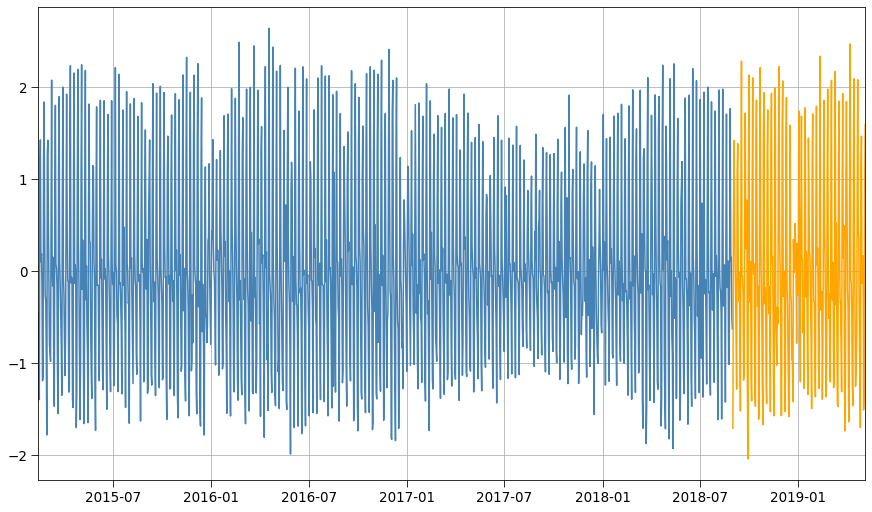

<IPython.core.display.Javascript object>

In [11]:
fig = plot_ts(train_intv.view(trans_ts))
plot_ts(val_intv.view(trans_ts), color="orange", fig=fig)
display(fig)

## Datasets

In [18]:
days_of_week_ts = pd.Series(trans_ts.index.dayofweek, index=trans_ts.index)
days_of_week_dct = get_exogenous_seasonal_dct_lst([days_of_week_ts])
days_of_week = len(days_of_week_dct[0])
max_window_len = 50

tw_seasonal_train_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
)
tw_seasonal_val_dataset = TimeWindowForecastingDataset(
    trans_ts,
    val_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
)


tw_train_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
)
tw_val_dataset = TimeWindowForecastingDataset(
    trans_ts,
    val_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
)

<IPython.core.display.Javascript object>

## Network

In [164]:
class ConvForecaster(nn.Module):
    def __init__(self, exogenous_len=None):
        super().__init__()
        self.base_net = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv1_1",
                        nn.Conv1d(1, 6, 3, padding=0, stride=1, bias=False),
                    ),  ## x: 21 -> 19
                    ("bn1_1", nn.BatchNorm1d(6)),
                    ("sigm1_1", nn.Sigmoid()),
                    ("maxp1", nn.MaxPool1d(2, padding=1, stride=2)),  # x: 19 -> 10
                    #                     ("dropout1", nn.Dropout(0.2)),
                    (
                        "conv2_1",
                        nn.Conv1d(6, 32, 3, padding=0, stride=1, bias=False),
                    ),  # x: 10 -> 8
                    ("bn2_1", nn.BatchNorm1d(32)),
                    ("sigm2_1", nn.Sigmoid()),
                    ("maxp2", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 8 -> 4
                    ("dropout2_1", nn.Dropout(0.5)),
                    (
                        "conv2_2",
                        nn.Conv1d(32, 128, 3, padding=0, stride=1, bias=False),
                    ),  # x: 4 -> 2
                    ("bn2_2", nn.BatchNorm1d(128)),
                    ("sigm2_2", nn.Sigmoid()),
                    ("dropout2_2", nn.Dropout(0.5)),
                    ("flatten1", nn.Flatten()),
                    ("fc1", nn.Linear(2 * 128, 64, bias=False)),
                    ("bn1", nn.BatchNorm1d(64)),
                    ("sigm1", nn.Sigmoid()),
                    ("dropout", nn.Dropout(0.5)),
                    ("fc2", nn.Linear(64, pred_steps, bias=True)),
                ]
            )
        )

        self.exogenous_len = exogenous_len
        if self.exogenous_len is not None:
            self.seasonal_head = nn.Sequential(
                OrderedDict(
                    [
                        ("seasonal_flatten1", nn.Flatten()),
                        (
                            "seasonal_fc1",
                            nn.Linear(pred_steps * (exogenous_len + 1), 5, bias=False),
                        ),
                        ("seasonal_bn1", nn.BatchNorm1d(5)),
                        ("seasonal_sigm1", nn.Sigmoid()),
                        ("seasonal_fc2", nn.Linear(5, pred_steps, bias=True)),
                        #                         (
                        #                             "seasonal_conv",
                        #                             nn.Conv1d(
                        #                                 exogenous_len + 1,
                        #                                 4,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=False,
                        #                             ),
                        #                         ),
                        #                         ("seasonal_bn1", nn.BatchNorm1d(4)),
                        #                         ("seasonal_sigm1", nn.Sigmoid()),
                        #                         (
                        #                             "seasonal_conv2",
                        #                             nn.Conv1d(
                        #                                 4,
                        #                                 1,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=True,
                        #                             ),
                        #                         ),
                    ]
                )
            )

    def forward(self, x, ex=None):
        #         print(x.shape)
        #         print(x)
        #         if x.shape[0] == 1:
        #             x = x.reshape((1, x.shape[1], x.shape[2]))
        #         print(x.shape)
        #         print(x)
        x = self.base_net.forward(x)
        if ex is not None:
            #             print(x)
            #             print(x.shape)
            #             print(ex.shape)
            x = x.reshape((x.shape[0], 1, x.shape[1]))
            #             print(x.shape)
            #             print(x)
            #             print(ex)
            x = torch.cat((x, ex), 1)
            #             print(x)
            #                         x = x.reshape((1, x.shape[0], x.shape[1]))
            #             print(x)
            #             print(x.shape)
            x = self.seasonal_head(x)
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        return x

    def set_base_params(self, trainable=True):
        for param in self.base_net.parameters():
            param.requires_grad = True

<IPython.core.display.Javascript object>

## Training

### Plain network

Epoch   10:   train_loss: 4.947, val_loss: 8.898, val_mae: 820, elapsed time: 5.8s  elapsed time: 5.8s 
Epoch   20:   train_loss: 4.575, val_loss: 8.258, val_mae: 773, elapsed time: 5.4s  elapsed time: 5.4s 
Epoch   30:   train_loss: 4.297, val_loss: 7.168, val_mae: 713, elapsed time: 5.3s  elapsed time: 5.3s 
Epoch   40:   train_loss: 3.974, val_loss: 6.547, val_mae: 671, elapsed time: 5.4s  elapsed time: 5.4s 
Epoch   50:   train_loss: 3.830, val_loss: 6.274, val_mae: 641, elapsed time: 5.4s  elapsed time: 5.4s 
Epoch   60:   train_loss: 3.627, val_loss: 6.051, val_mae: 627, elapsed time: 5.4s  elapsed time: 5.4s 
Epoch   70:   train_loss: 3.526, val_loss: 5.895, val_mae: 621, elapsed time: 5.3s  elapsed time: 5.3s 
Epoch   80:   train_loss: 3.387, val_loss: 5.780, val_mae: 609, elapsed time: 5.3s  elapsed time: 5.3s 
Epoch   90:   train_loss: 3.338, val_loss: 5.651, val_mae: 607, elapsed time: 5.6s  elapsed time: 5.6s 
Epoch  100:   train_loss: 3.237, val_loss: 5.575, val_mae: 601, 

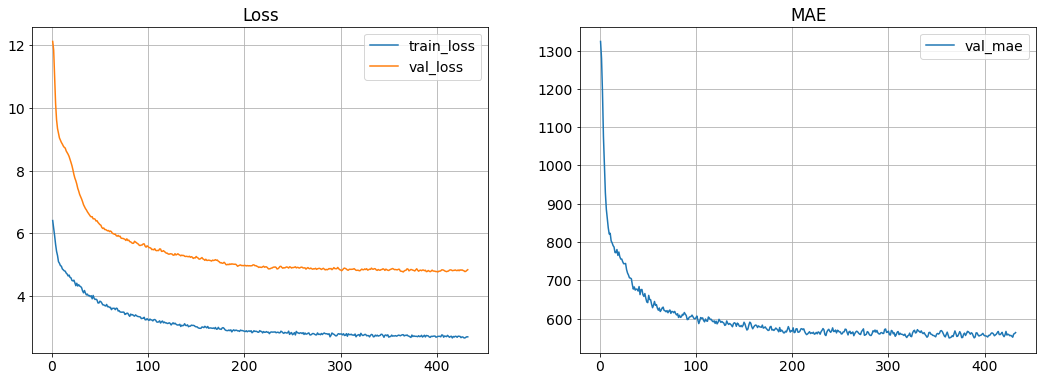

<IPython.core.display.Javascript object>

In [165]:
conv_forecaster = ConvForecaster(exogenous_len=days_of_week).to(device)
window_len = 21

huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.2)
mae_loss = torch.nn.L1Loss(reduction="sum")
original_mae = OriginalMetric(trans, "MAE")

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=50, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "MAE", "val_mae", n_epochs=60, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)

tw_train_dataset.set(window_len=window_len)
tw_val_dataset.set(window_len=window_len)

tw_train_loader = DataLoader(tw_train_dataset, batch_size=100, shuffle=False)
tw_val_loader = DataLoader(tw_val_dataset, batch_size=100)

history = {}
fit(
    conv_forecaster,
    device,
    "Adam",
    mae_loss,
    tw_train_loader,
    tw_val_loader,
    metrics=[original_mae],
    metrics_val_only=True,
    lr=1e-2,
    n_epochs=500,
    stop_cond=val_stopping,
    history=history,
)
plot_history(history)

### Seasonal Network

Epoch    1:   train_loss: 2.555, val_loss: 5.110, val_mae: 1842, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    2:   train_loss: 2.441, val_loss: 4.919, val_mae: 1773, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    3:   train_loss: 2.359, val_loss: 4.747, val_mae: 1714, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    4:   train_loss: 2.296, val_loss: 4.625, val_mae: 1669, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    5:   train_loss: 2.242, val_loss: 4.531, val_mae: 1631, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    6:   train_loss: 2.194, val_loss: 4.454, val_mae: 1597, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    7:   train_loss: 2.152, val_loss: 4.387, val_mae: 1564, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    8:   train_loss: 2.114, val_loss: 4.329, val_mae: 1532, elapsed time: 0.5s elapsed time: 0.5s 
Epoch    9:   train_loss: 2.080, val_loss: 4.274, val_mae: 1503, elapsed time: 0.5s elapsed time: 0.5s 
Epoch   10:   train_loss: 2.049, val_loss: 4.223, val_mae: 1475,

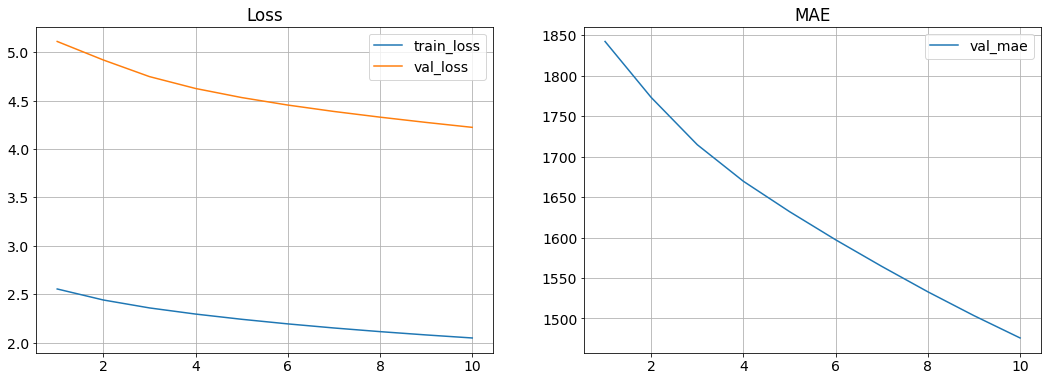

<IPython.core.display.Javascript object>

In [84]:
seasonal_conv_forecaster = ConvForecaster(exogenous_len=days_of_week).to(device)

huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.5)
original_mae = OriginalMetric(trans, "MAE")

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=20, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "MAE", "val_mae", n_epochs=30, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)

tw_seasonal_train_dataset.set(window_len=21)
tw_seasonal_val_dataset.set(window_len=21)

tw_seasonal_train_loader = DataLoader(
    tw_seasonal_train_dataset, batch_size=100, shuffle=False
)
tw_seasonal_val_loader = DataLoader(tw_seasonal_val_dataset, batch_size=100)

history = {}
fit(
    seasonal_conv_forecaster,
    device,
    "Adam",
    huber_loss,
    tw_seasonal_train_loader,
    tw_seasonal_val_loader,
    metrics=[original_mae],
    metrics_val_only=True,
    lr=1e-4,
    n_epochs=10,
    stop_cond=val_stopping,
    history=history,
)
plot_history(history)

## Validation

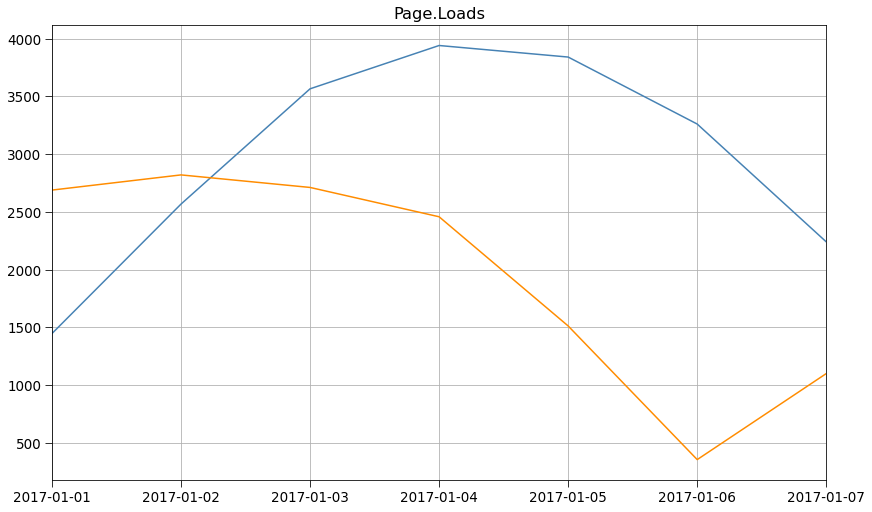

<IPython.core.display.Javascript object>

In [167]:
intv = tss.Interval(
    trans_ts, datetime(2017, 1, 1), datetime(2017, 1, 1) + timedelta(days=pred_steps)
)
model = TimeWindowForecastingModel(
    conv_forecaster,
    window_len,
    device,
    detrans=trans,
)
pred = model.predict(trans_ts, intv, original_ts=ts)
fig = plot_ts(intv.view(ts))
plot_ts(pred, color="darkorange", fig=fig)

In [166]:
%%time
conv_forecaster.eval()
model = TimeWindowForecastingModel(conv_forecaster, window_len, device)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
model_name = "Stacked Convs"
model_version = "plain"
pprint(val_mean_scores)

61/61 – MAE: 1179.1, elapsed time: 1.1s (last: 0.0s)      

{'MAE': 1179.1361978405814}
CPU times: user 1.11 s, sys: 16.6 ms, total: 1.13 s
Wall time: 2.14 s


<IPython.core.display.Javascript object>

In [82]:
%%time
seasonal_conv_forecaster.eval()
seasonal_model = TimeWindowForecastingModel(seasonal_conv_forecaster, window_len, device, seasons_dct_lst=days_of_week_dct_lst)
seasonal_model.fit(trans_ts, train_intv)
seasonal_val_mean_scores, seasonal_val_all_scores, seasonal_val_preds = average_scores(
    seasonal_model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    seasonal_ts_seq=[days_of_week_ts],
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
seasonal_model_name = "Stacked Convs"
seasonal_model_version = "seasonal"
pprint(seasonal_val_mean_scores)

61/61 – MAE: 1246.27312, elapsed time: 1.6s (last: 0.0s)      
{'MAE': 1246.2731213551492}
CPU times: user 1.61 s, sys: 23.2 ms, total: 1.63 s
Wall time: 1.61 s


<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [83]:
scoring_name = "MAE"
fig = plot_hist_model_scores(
    val_all_scores,
    scoring_name,
    data_name=data_name,
    model_name=model_name,
    model_version=model_version,
    in_label=True,
    engine="plotly",
)
plot_hist_model_scores(
    seasonal_val_all_scores,
    scoring_name,
    data_name=data_name,
    model_name=seasonal_model_name,
    model_version=seasonal_model_version,
    in_label=True,
    fig=fig,
)
display(fig)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

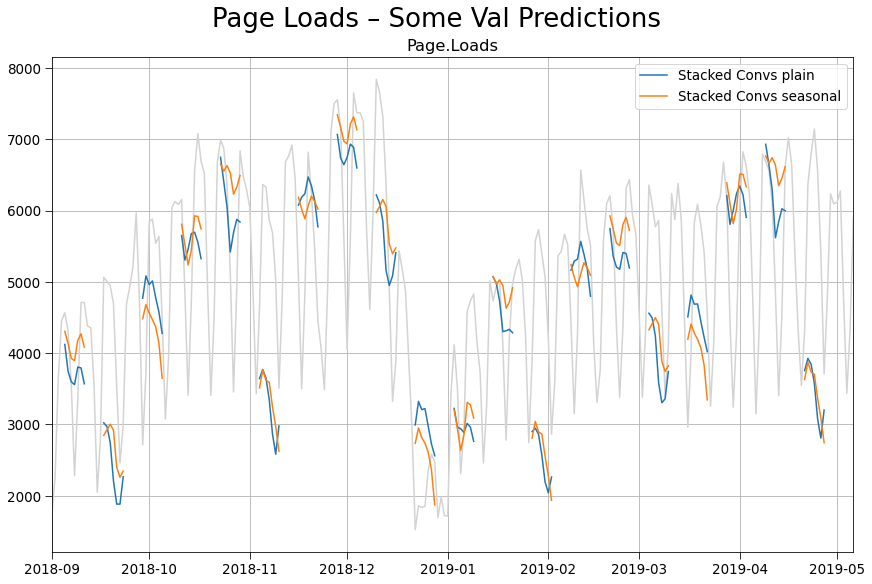

<IPython.core.display.Javascript object>

In [84]:
fig_time_delta = timedelta(days=3)
fig = plot_ground_truth(val_intv, mode="val", data_name=data_name, color="lightgrey")
plot_model_test_prediction(
    val_intv,
    fig_time_delta,
    val_preds,
    model_name=model_name,
    model_version=model_version,
    color="tab:blue",
    fig=fig,
)
plot_model_test_prediction(
    val_intv,
    fig_time_delta,
    seasonal_val_preds,
    model_name=seasonal_model_name,
    model_version=seasonal_model_version,
    color="tab:orange",
    fig=fig,
)
display(fig)

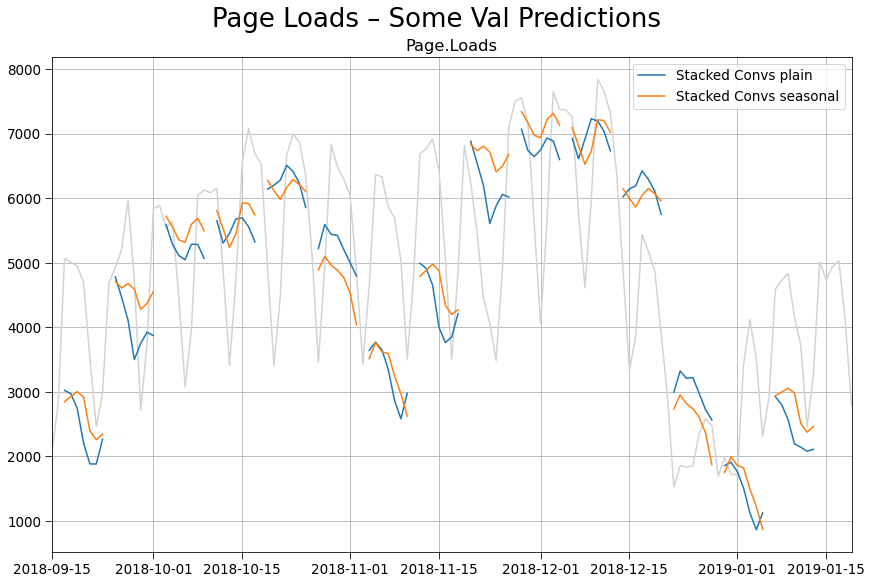

<IPython.core.display.Javascript object>

In [85]:
short_val_intv = tss.Interval(ts, datetime(2018, 9, 15), datetime(2019, 1, 20))
fig_time_delta = timedelta(days=1)
fig = plot_ground_truth(
    short_val_intv, mode="val", data_name=data_name, color="lightgrey"
)
plot_model_test_prediction(
    short_val_intv,
    fig_time_delta,
    val_preds,
    model_name=model_name,
    model_version=model_version,
    color="tab:blue",
    fig=fig,
)
plot_model_test_prediction(
    short_val_intv,
    fig_time_delta,
    seasonal_val_preds,
    model_name=seasonal_model_name,
    model_version=seasonal_model_version,
    color="tab:orange",
    fig=fig,
)
display(fig)

## Test Predictions

In [48]:
%%time
model.update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    trans_ts,
    test_intv,
    trans=trans,
    original_ts=ts,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

116/116 – RMSE: 415.85077, MAE: 352.52186, MASE: 0.58415, sMAPE: 9.98638, elapsed time: 8min 26s (last: 4.8s)       
{'MAE': 352.52185685004883,
 'MASE': 0.5841498115401095,
 'RMSE': 415.8507678766239,
 'sMAPE': 9.986377121901569}
CPU times: user 5min 33s, sys: 3min 54s, total: 9min 28s
Wall time: 8min 31s


<IPython.core.display.Javascript object>